# Train Dataset

In [ ]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import cv2
import os
from torchvision.transforms import transforms
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
# define the training dataset
class MandibleDataset(Dataset):
    def __init__(self, path_to_images, path_to_masks, transform=None):
        self.path_to_images = path_to_images
        self.path_to_masks = path_to_masks
        self.transform = transform
        self.images = []
        self.masks = []

        for filename in os.listdir(self.path_to_images):
            img = cv2.imread(os.path.join(self.path_to_images, filename), 0)
            img = cv2.resize(img, (900, 400))
            img = self.pad(img)
            img -= img.min()
            img = img.astype(np.float32) / img.max()
            self.images.append(img)

        i = -1
        for filename in os.listdir(self.path_to_masks):
            i += 1
            mask = cv2.imread(os.path.join(self.path_to_masks, filename), 0)
            mask = cv2.resize(mask, (900, 400))
            mask = self.pad(mask)
            mask -= mask.min()
            mask = mask.astype(np.float32) / mask.max()
            mask = np.where(mask == np.unique(mask)[0], 0, 1)
            self.masks.append(mask)

    def pad(self, img):
        x = img.shape[0] - img.shape[0] % 32
        y = img.shape[1] - img.shape[1] % 32
        img = img[:x, :y]
        return img

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform is not None:
            image = self.transform(image).contiguous()
            mask = self.transform(mask).contiguous()
        return image, mask

def Dice(output, target, weight=None, eps=1e-5):
    target = target.float()
    if weight is None:
        num = 2 * (output * target).sum()
        den = output.sum() + target.sum() + eps
    return 1.0 - num / den

In [ ]:
# define the training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    total_dice = 0
    total_iou = 0
    total_correct = 0
    total_samples = 0

    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        target = target.squeeze(1).long()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        total_dice += Dice(output[:, 0, :, :], target).item()
        total_iou += IoU(output[:, 0, :, :], target).item()  # Implement IoU calculation
        total_correct += accuracy(output, target).item()  # Implement accuracy calculation
        total_samples += data.size(0)

    train_loss /= len(train_loader)
    total_dice /= len(train_loader)
    total_iou /= len(train_loader)
    train_acc = total_correct / total_samples

    return train_loss, total_dice, total_iou, train_acc

# define the validation function
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0
    total_dice = 0
    total_iou = 0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze(1).long()
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()

            total_dice += Dice(output[:, 0, :, :], target).item()
            total_iou += IoU(output[:, 0, :, :], target).item()  # Implement IoU calculation
            total_correct += accuracy(output, target).item()  # Implement accuracy calculation
            total_samples += data.size(0)

    val_loss /= len(val_loader)
    total_dice /= len(val_loader)
    total_iou /= len(val_loader)
    val_acc = total_correct / total_samples

    return val_loss, total_dice, total_iou, val_acc

def IoU(output, target):
    smooth = 1e-5
    output = torch.sigmoid(output) > 0.5
    iou = 0
    for th in range(1):
        pred = output[:, th]
        truth = target == th
        intersection = (pred & truth).sum()
        union = pred.sum() + truth.sum() - intersection
        iou += (intersection + smooth) / (union + smooth)

    return iou / output.size(1)

def accuracy(output, target):
    output = torch.sigmoid(output) > 0.5
    correct = (output == target).sum()
    total = target.numel()
    return correct / total

# define the function to plot the train and validation loss
def plot_loss(train_loss, val_loss):
    plt.plot(train_loss, label='Train loss')
    plt.plot(val_loss, label='Validation loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# define the function to plot the train and validation dice score
def plot_dice(train_dice, val_dice):
    plt.plot(train_dice, label='Train dice score')
    plt.plot(val_dice, label='Validation dice score')
    plt.title('Train and Validation Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice score')
    plt.legend()
    plt.show()

# define the function to plot the train and validation IoU
def plot_iou(train_iou, val_iou):
    plt.plot(train_iou, label='Train IoU')
    plt.plot(val_iou, label='Validation IoU')
    plt.title('Train and Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.show()

# define the function to plot the train and validation accuracy
def plot_accuracy(train_acc, val_acc):
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

<ipython-input-4-cd927a15fa60>:25: RuntimeWarning: invalid value encountered in divide
  mask = mask.astype(np.float32) / mask.max()


Epoch 1/100


100%|██████████| 60/60 [00:06<00:00,  9.34it/s]


Train loss: 0.420754, Train dice score: 0.481857, Train IoU: 0.509989, Train accuracy: 0.980027
Validation loss: 0.440767, Validation dice score: 0.565889, Validation IoU: 0.587747, Validation accuracy: 0.824644
Epoch 2/100


100%|██████████| 60/60 [00:06<00:00,  9.62it/s]


Train loss: 0.387949, Train dice score: 0.555383, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.415578, Validation dice score: 0.625763, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 3/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.372619, Train dice score: 0.590383, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.405990, Validation dice score: 0.654433, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 4/100


100%|██████████| 60/60 [00:06<00:00,  9.43it/s]


Train loss: 0.363659, Train dice score: 0.613021, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.399491, Validation dice score: 0.671796, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 5/100


100%|██████████| 60/60 [00:06<00:00,  9.38it/s]


Train loss: 0.357256, Train dice score: 0.630151, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.396737, Validation dice score: 0.685206, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 6/100


100%|██████████| 60/60 [00:06<00:00,  9.15it/s]


Train loss: 0.352829, Train dice score: 0.642867, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.391228, Validation dice score: 0.696946, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 7/100


100%|██████████| 60/60 [00:06<00:00,  9.37it/s]


Train loss: 0.348857, Train dice score: 0.654188, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.388084, Validation dice score: 0.710402, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 8/100


100%|██████████| 60/60 [00:06<00:00,  9.37it/s]


Train loss: 0.344789, Train dice score: 0.665253, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.384476, Validation dice score: 0.716542, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 9/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.341371, Train dice score: 0.675564, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.383521, Validation dice score: 0.723594, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 10/100


100%|██████████| 60/60 [00:06<00:00,  9.49it/s]


Train loss: 0.338101, Train dice score: 0.686441, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.380491, Validation dice score: 0.730578, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 11/100


100%|██████████| 60/60 [00:06<00:00,  9.60it/s]


Train loss: 0.334947, Train dice score: 0.696453, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.377068, Validation dice score: 0.741429, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 12/100


100%|██████████| 60/60 [00:06<00:00,  9.52it/s]


Train loss: 0.331924, Train dice score: 0.704784, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.374072, Validation dice score: 0.755056, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 13/100


100%|██████████| 60/60 [00:06<00:00,  9.37it/s]


Train loss: 0.329217, Train dice score: 0.710244, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.372403, Validation dice score: 0.749190, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 14/100


100%|██████████| 60/60 [00:06<00:00,  9.49it/s]


Train loss: 0.326437, Train dice score: 0.714991, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.370696, Validation dice score: 0.755441, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 15/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.323973, Train dice score: 0.718543, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.366940, Validation dice score: 0.759231, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 16/100


100%|██████████| 60/60 [00:06<00:00,  9.51it/s]


Train loss: 0.321586, Train dice score: 0.722200, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.365675, Validation dice score: 0.769077, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 17/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.319369, Train dice score: 0.725763, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.365658, Validation dice score: 0.760916, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 18/100


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


Train loss: 0.317289, Train dice score: 0.729548, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.362558, Validation dice score: 0.772050, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 19/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.315275, Train dice score: 0.733393, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.361400, Validation dice score: 0.777388, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 20/100


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


Train loss: 0.313261, Train dice score: 0.737448, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.361677, Validation dice score: 0.771318, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 21/100


100%|██████████| 60/60 [00:06<00:00,  9.39it/s]


Train loss: 0.311406, Train dice score: 0.741334, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.358862, Validation dice score: 0.779116, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 22/100


100%|██████████| 60/60 [00:06<00:00,  9.53it/s]


Train loss: 0.309785, Train dice score: 0.745129, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.357984, Validation dice score: 0.780023, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 23/100


100%|██████████| 60/60 [00:06<00:00,  9.52it/s]


Train loss: 0.308102, Train dice score: 0.749176, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.355217, Validation dice score: 0.784717, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 24/100


100%|██████████| 60/60 [00:06<00:00,  9.51it/s]


Train loss: 0.306522, Train dice score: 0.753212, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.355890, Validation dice score: 0.782448, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 25/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.304825, Train dice score: 0.757518, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.356048, Validation dice score: 0.784450, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 26/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.303302, Train dice score: 0.761675, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.353594, Validation dice score: 0.799654, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 27/100


100%|██████████| 60/60 [00:06<00:00,  9.54it/s]


Train loss: 0.301945, Train dice score: 0.765517, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.349444, Validation dice score: 0.805736, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 28/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.300588, Train dice score: 0.769227, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.354035, Validation dice score: 0.789795, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 29/100


100%|██████████| 60/60 [00:06<00:00,  9.49it/s]


Train loss: 0.299080, Train dice score: 0.773604, Train IoU: 0.509989, Train accuracy: 0.980022
Validation loss: 0.351022, Validation dice score: 0.808485, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 30/100


100%|██████████| 60/60 [00:06<00:00,  9.40it/s]


Train loss: 0.297753, Train dice score: 0.777285, Train IoU: 0.509989, Train accuracy: 0.980021
Validation loss: 0.349821, Validation dice score: 0.806924, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 31/100


100%|██████████| 60/60 [00:06<00:00,  9.49it/s]


Train loss: 0.296514, Train dice score: 0.781122, Train IoU: 0.509989, Train accuracy: 0.980021
Validation loss: 0.352333, Validation dice score: 0.793055, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 32/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.295186, Train dice score: 0.785011, Train IoU: 0.509989, Train accuracy: 0.980016
Validation loss: 0.347599, Validation dice score: 0.809710, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 33/100


100%|██████████| 60/60 [00:06<00:00,  9.51it/s]


Train loss: 0.294087, Train dice score: 0.788553, Train IoU: 0.509989, Train accuracy: 0.980011
Validation loss: 0.348694, Validation dice score: 0.803347, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 34/100


100%|██████████| 60/60 [00:06<00:00,  9.39it/s]


Train loss: 0.292859, Train dice score: 0.792366, Train IoU: 0.509989, Train accuracy: 0.979956
Validation loss: 0.346670, Validation dice score: 0.817671, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 35/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.291731, Train dice score: 0.795903, Train IoU: 0.509989, Train accuracy: 0.979909
Validation loss: 0.349752, Validation dice score: 0.793177, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 36/100


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


Train loss: 0.290674, Train dice score: 0.799347, Train IoU: 0.509989, Train accuracy: 0.979849
Validation loss: 0.347552, Validation dice score: 0.811309, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 37/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.289625, Train dice score: 0.802926, Train IoU: 0.509989, Train accuracy: 0.979692
Validation loss: 0.341461, Validation dice score: 0.821890, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 38/100


100%|██████████| 60/60 [00:06<00:00,  9.52it/s]


Train loss: 0.288665, Train dice score: 0.806047, Train IoU: 0.509989, Train accuracy: 0.979545
Validation loss: 0.340080, Validation dice score: 0.833027, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 39/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.287694, Train dice score: 0.809284, Train IoU: 0.509989, Train accuracy: 0.979533
Validation loss: 0.344604, Validation dice score: 0.831804, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 40/100


100%|██████████| 60/60 [00:06<00:00,  9.52it/s]


Train loss: 0.286532, Train dice score: 0.813019, Train IoU: 0.509989, Train accuracy: 0.979312
Validation loss: 0.346035, Validation dice score: 0.816932, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 41/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.285740, Train dice score: 0.815852, Train IoU: 0.509989, Train accuracy: 0.979219
Validation loss: 0.342983, Validation dice score: 0.834107, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 42/100


100%|██████████| 60/60 [00:06<00:00,  9.44it/s]


Train loss: 0.284897, Train dice score: 0.818796, Train IoU: 0.509989, Train accuracy: 0.979042
Validation loss: 0.336668, Validation dice score: 0.844760, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 43/100


100%|██████████| 60/60 [00:06<00:00,  9.37it/s]


Train loss: 0.283935, Train dice score: 0.822003, Train IoU: 0.509989, Train accuracy: 0.978908
Validation loss: 0.340459, Validation dice score: 0.839050, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 44/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.283031, Train dice score: 0.825090, Train IoU: 0.509989, Train accuracy: 0.978663
Validation loss: 0.335753, Validation dice score: 0.855904, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 45/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.282349, Train dice score: 0.827816, Train IoU: 0.509989, Train accuracy: 0.978504
Validation loss: 0.338525, Validation dice score: 0.843564, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 46/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.281471, Train dice score: 0.830771, Train IoU: 0.509989, Train accuracy: 0.978363
Validation loss: 0.335215, Validation dice score: 0.862864, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 47/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.280591, Train dice score: 0.833624, Train IoU: 0.509989, Train accuracy: 0.978203
Validation loss: 0.336436, Validation dice score: 0.847264, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 48/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.279804, Train dice score: 0.836507, Train IoU: 0.509989, Train accuracy: 0.978020
Validation loss: 0.336445, Validation dice score: 0.852860, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 49/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.279133, Train dice score: 0.839125, Train IoU: 0.509989, Train accuracy: 0.977923
Validation loss: 0.337399, Validation dice score: 0.843090, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 50/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.278469, Train dice score: 0.841597, Train IoU: 0.509989, Train accuracy: 0.977709
Validation loss: 0.337603, Validation dice score: 0.845692, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 51/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.277712, Train dice score: 0.844214, Train IoU: 0.509989, Train accuracy: 0.977592
Validation loss: 0.335764, Validation dice score: 0.847850, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 52/100


100%|██████████| 60/60 [00:06<00:00,  9.40it/s]


Train loss: 0.277061, Train dice score: 0.846722, Train IoU: 0.509989, Train accuracy: 0.977468
Validation loss: 0.331566, Validation dice score: 0.862901, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 53/100


100%|██████████| 60/60 [00:06<00:00,  9.53it/s]


Train loss: 0.276392, Train dice score: 0.849240, Train IoU: 0.509989, Train accuracy: 0.977264
Validation loss: 0.332748, Validation dice score: 0.864421, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 54/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.275675, Train dice score: 0.851703, Train IoU: 0.509989, Train accuracy: 0.977153
Validation loss: 0.337456, Validation dice score: 0.844033, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 55/100


100%|██████████| 60/60 [00:06<00:00,  9.52it/s]


Train loss: 0.275085, Train dice score: 0.854072, Train IoU: 0.509989, Train accuracy: 0.976947
Validation loss: 0.333741, Validation dice score: 0.863565, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 56/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.274557, Train dice score: 0.856236, Train IoU: 0.509989, Train accuracy: 0.976745
Validation loss: 0.330113, Validation dice score: 0.874877, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 57/100


100%|██████████| 60/60 [00:06<00:00,  9.51it/s]


Train loss: 0.273941, Train dice score: 0.858475, Train IoU: 0.509989, Train accuracy: 0.976537
Validation loss: 0.329346, Validation dice score: 0.874262, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 58/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.273386, Train dice score: 0.860677, Train IoU: 0.509989, Train accuracy: 0.976344
Validation loss: 0.335552, Validation dice score: 0.852256, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 59/100


100%|██████████| 60/60 [00:06<00:00,  9.49it/s]


Train loss: 0.272795, Train dice score: 0.862964, Train IoU: 0.509989, Train accuracy: 0.976209
Validation loss: 0.332480, Validation dice score: 0.861871, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 60/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.272225, Train dice score: 0.865139, Train IoU: 0.509989, Train accuracy: 0.975882
Validation loss: 0.331833, Validation dice score: 0.868020, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 61/100


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


Train loss: 0.271786, Train dice score: 0.866929, Train IoU: 0.509989, Train accuracy: 0.975600
Validation loss: 0.327831, Validation dice score: 0.888788, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 62/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.271189, Train dice score: 0.869182, Train IoU: 0.509989, Train accuracy: 0.975386
Validation loss: 0.324675, Validation dice score: 0.891408, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 63/100


100%|██████████| 60/60 [00:06<00:00,  9.43it/s]


Train loss: 0.270733, Train dice score: 0.871108, Train IoU: 0.509989, Train accuracy: 0.975195
Validation loss: 0.331896, Validation dice score: 0.868635, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 64/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.270189, Train dice score: 0.873071, Train IoU: 0.509989, Train accuracy: 0.974915
Validation loss: 0.328089, Validation dice score: 0.884151, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 65/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.269856, Train dice score: 0.874764, Train IoU: 0.509989, Train accuracy: 0.974710
Validation loss: 0.325080, Validation dice score: 0.883936, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 66/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.269351, Train dice score: 0.876669, Train IoU: 0.509989, Train accuracy: 0.974393
Validation loss: 0.323177, Validation dice score: 0.893720, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 67/100


100%|██████████| 60/60 [00:06<00:00,  9.39it/s]


Train loss: 0.268904, Train dice score: 0.878517, Train IoU: 0.509989, Train accuracy: 0.974118
Validation loss: 0.323397, Validation dice score: 0.893346, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 68/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.268379, Train dice score: 0.880391, Train IoU: 0.509989, Train accuracy: 0.973868
Validation loss: 0.326486, Validation dice score: 0.882320, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 69/100


100%|██████████| 60/60 [00:06<00:00,  9.42it/s]


Train loss: 0.267990, Train dice score: 0.882128, Train IoU: 0.509989, Train accuracy: 0.973528
Validation loss: 0.326242, Validation dice score: 0.893234, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 70/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.267729, Train dice score: 0.883485, Train IoU: 0.509989, Train accuracy: 0.973374
Validation loss: 0.328076, Validation dice score: 0.880683, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 71/100


100%|██████████| 60/60 [00:06<00:00,  9.39it/s]


Train loss: 0.267244, Train dice score: 0.885234, Train IoU: 0.509989, Train accuracy: 0.973115
Validation loss: 0.323030, Validation dice score: 0.908324, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 72/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.266844, Train dice score: 0.886886, Train IoU: 0.509989, Train accuracy: 0.972851
Validation loss: 0.323410, Validation dice score: 0.902924, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 73/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.266471, Train dice score: 0.888473, Train IoU: 0.509989, Train accuracy: 0.972594
Validation loss: 0.321799, Validation dice score: 0.900540, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 74/100


100%|██████████| 60/60 [00:06<00:00,  9.46it/s]


Train loss: 0.266161, Train dice score: 0.889940, Train IoU: 0.509989, Train accuracy: 0.972390
Validation loss: 0.321585, Validation dice score: 0.899573, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 75/100


100%|██████████| 60/60 [00:06<00:00,  9.51it/s]


Train loss: 0.265753, Train dice score: 0.891488, Train IoU: 0.509989, Train accuracy: 0.972189
Validation loss: 0.321141, Validation dice score: 0.900936, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 76/100


100%|██████████| 60/60 [00:06<00:00,  9.38it/s]


Train loss: 0.265474, Train dice score: 0.892840, Train IoU: 0.509989, Train accuracy: 0.971866
Validation loss: 0.324023, Validation dice score: 0.896357, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 77/100


100%|██████████| 60/60 [00:06<00:00,  9.50it/s]


Train loss: 0.265055, Train dice score: 0.894579, Train IoU: 0.509989, Train accuracy: 0.971660
Validation loss: 0.325826, Validation dice score: 0.896484, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 78/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.264812, Train dice score: 0.895627, Train IoU: 0.509989, Train accuracy: 0.971531
Validation loss: 0.322751, Validation dice score: 0.915853, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 79/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.264495, Train dice score: 0.897078, Train IoU: 0.509989, Train accuracy: 0.971338
Validation loss: 0.321785, Validation dice score: 0.906907, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 80/100


100%|██████████| 60/60 [00:06<00:00,  9.43it/s]


Train loss: 0.264194, Train dice score: 0.898317, Train IoU: 0.509989, Train accuracy: 0.971058
Validation loss: 0.320342, Validation dice score: 0.906266, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 81/100


100%|██████████| 60/60 [00:06<00:00,  9.54it/s]


Train loss: 0.263886, Train dice score: 0.899833, Train IoU: 0.509989, Train accuracy: 0.970915
Validation loss: 0.318935, Validation dice score: 0.917814, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 82/100


100%|██████████| 60/60 [00:06<00:00,  9.43it/s]


Train loss: 0.263538, Train dice score: 0.901004, Train IoU: 0.509989, Train accuracy: 0.970734
Validation loss: 0.324024, Validation dice score: 0.905557, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 83/100


100%|██████████| 60/60 [00:06<00:00,  9.49it/s]


Train loss: 0.263337, Train dice score: 0.902211, Train IoU: 0.509989, Train accuracy: 0.970630
Validation loss: 0.318197, Validation dice score: 0.917200, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 84/100


100%|██████████| 60/60 [00:06<00:00,  9.48it/s]


Train loss: 0.263044, Train dice score: 0.903392, Train IoU: 0.509989, Train accuracy: 0.970301
Validation loss: 0.322824, Validation dice score: 0.898206, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 85/100


100%|██████████| 60/60 [00:06<00:00,  9.43it/s]


Train loss: 0.262748, Train dice score: 0.904667, Train IoU: 0.509989, Train accuracy: 0.970236
Validation loss: 0.319670, Validation dice score: 0.921880, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 86/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.262508, Train dice score: 0.905768, Train IoU: 0.509989, Train accuracy: 0.970070
Validation loss: 0.321842, Validation dice score: 0.901322, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 87/100


100%|██████████| 60/60 [00:06<00:00,  9.45it/s]


Train loss: 0.262228, Train dice score: 0.906904, Train IoU: 0.509989, Train accuracy: 0.969953
Validation loss: 0.319015, Validation dice score: 0.916684, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 88/100


100%|██████████| 60/60 [00:06<00:00,  9.44it/s]


Train loss: 0.261983, Train dice score: 0.908134, Train IoU: 0.509989, Train accuracy: 0.969767
Validation loss: 0.321722, Validation dice score: 0.912449, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 89/100


100%|██████████| 60/60 [00:06<00:00,  9.38it/s]


Train loss: 0.261850, Train dice score: 0.908927, Train IoU: 0.509989, Train accuracy: 0.969760
Validation loss: 0.319700, Validation dice score: 0.910723, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 90/100


100%|██████████| 60/60 [00:06<00:00,  9.47it/s]


Train loss: 0.261616, Train dice score: 0.910084, Train IoU: 0.509989, Train accuracy: 0.969620
Validation loss: 0.320662, Validation dice score: 0.904969, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 91/100


100%|██████████| 60/60 [00:06<00:00,  9.36it/s]


Train loss: 0.261342, Train dice score: 0.911161, Train IoU: 0.509989, Train accuracy: 0.969558
Validation loss: 0.317663, Validation dice score: 0.921693, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 92/100


100%|██████████| 60/60 [00:06<00:00,  9.44it/s]


Train loss: 0.261149, Train dice score: 0.912081, Train IoU: 0.509989, Train accuracy: 0.969572
Validation loss: 0.317296, Validation dice score: 0.927953, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 93/100


100%|██████████| 60/60 [00:06<00:00,  9.30it/s]


Train loss: 0.260897, Train dice score: 0.913198, Train IoU: 0.509989, Train accuracy: 0.969438
Validation loss: 0.320112, Validation dice score: 0.917420, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 94/100


100%|██████████| 60/60 [00:06<00:00,  9.45it/s]


Train loss: 0.260694, Train dice score: 0.914113, Train IoU: 0.509989, Train accuracy: 0.969356
Validation loss: 0.319024, Validation dice score: 0.915912, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 95/100


100%|██████████| 60/60 [00:06<00:00,  9.26it/s]


Train loss: 0.260496, Train dice score: 0.915080, Train IoU: 0.509989, Train accuracy: 0.969465
Validation loss: 0.318474, Validation dice score: 0.922323, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 96/100


100%|██████████| 60/60 [00:06<00:00,  9.41it/s]


Train loss: 0.260302, Train dice score: 0.916083, Train IoU: 0.509989, Train accuracy: 0.969354
Validation loss: 0.317699, Validation dice score: 0.927624, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 97/100


100%|██████████| 60/60 [00:06<00:00,  9.28it/s]


Train loss: 0.260120, Train dice score: 0.916928, Train IoU: 0.509989, Train accuracy: 0.969261
Validation loss: 0.318693, Validation dice score: 0.914745, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 98/100


100%|██████████| 60/60 [00:06<00:00,  9.43it/s]


Train loss: 0.259957, Train dice score: 0.917832, Train IoU: 0.509989, Train accuracy: 0.969392
Validation loss: 0.320557, Validation dice score: 0.923303, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 99/100


100%|██████████| 60/60 [00:06<00:00,  9.27it/s]


Train loss: 0.259732, Train dice score: 0.918834, Train IoU: 0.509989, Train accuracy: 0.969481
Validation loss: 0.317135, Validation dice score: 0.927022, Validation IoU: 0.587747, Validation accuracy: 0.824506
Epoch 100/100


100%|██████████| 60/60 [00:06<00:00,  9.40it/s]


Train loss: 0.259494, Train dice score: 0.919827, Train IoU: 0.509989, Train accuracy: 0.969405
Validation loss: 0.318127, Validation dice score: 0.936341, Validation IoU: 0.587747, Validation accuracy: 0.824506


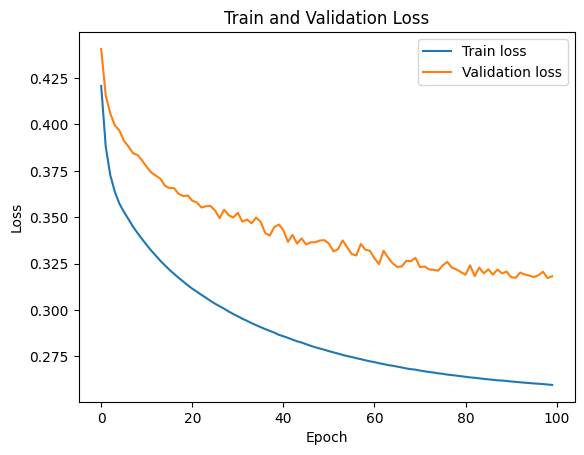

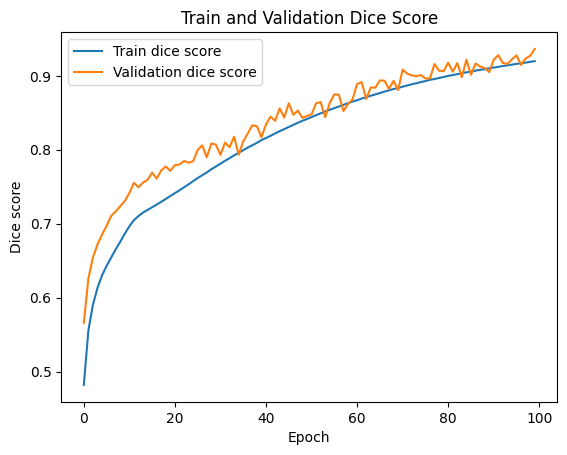

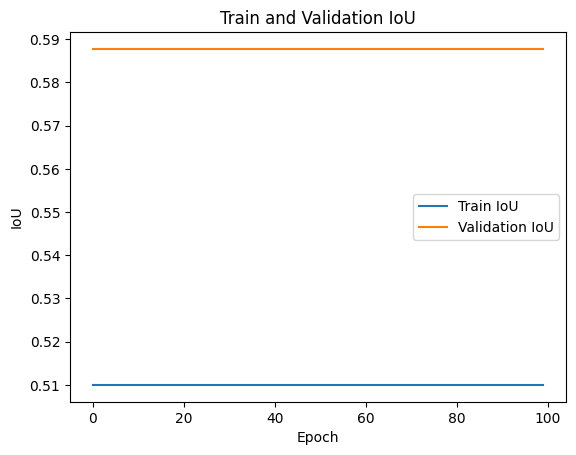

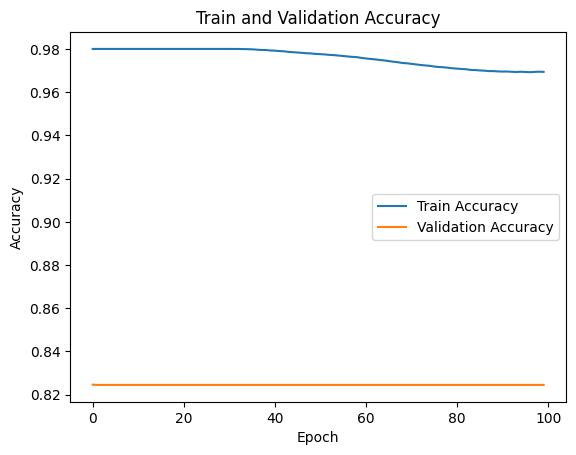

In [ ]:
def train_model(model, epochs, batch_size, learning_rate, device):
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    criterion = DiceLoss('multiclass')

    optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # define the training data loader
    path_to_images = '/content/drive/MyDrive/segmentasi/train/mandible/images'
    path_to_masks = '/content/drive/MyDrive/segmentasi/train/mandible/masks'
    dataset = MandibleDataset(path_to_images, path_to_masks, transform=transform)

    # Split into train / validation partitions
    n_val = int(len(dataset) * 0.2)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(13))

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True)

    # define the lists to store the train and validation loss and dice score
    train_loss_list = []
    val_loss_list = []
    train_dice_list = []
    val_dice_list = []
    train_iou_list = []
    val_iou_list = []
    train_acc_list = []
    val_acc_list = []

    min_val_loss = 1000

    # train the model
    for epoch in range(epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        train_loss, train_dice, train_iou, train_acc = train(model, device, train_loader, optimizer, criterion)
        print(f'Train loss: {train_loss:.6f}, Train dice score: {train_dice:.6f}, Train IoU: {train_iou:.6f}, Train accuracy: {train_acc:.6f}')
        val_loss, val_dice, val_iou, val_acc = validate(model, device, val_loader, criterion)
        print(f'Validation loss: {val_loss:.6f}, Validation dice score: {val_dice:.6f}, Validation IoU: {val_iou:.6f}, Validation accuracy: {val_acc:.6f}')

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        train_dice_list.append(train_dice)
        val_dice_list.append(val_dice)
        train_iou_list.append(train_iou)
        val_iou_list.append(val_iou)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        torch.save(model.state_dict(), f'checkpoints/unet_model_epoch{epoch + 1}.pth')
        if val_loss < min_val_loss:
            min_val_loss = val_loss
            torch.save(model.state_dict(), 'checkpoints/unet_model_best.pth')

    # plot the train and validation loss and dice score
    plot_loss(train_loss_list, val_loss_list)
    plot_dice(train_dice_list, val_dice_list)
    plot_iou(train_iou_list, val_iou_list)
    plot_accuracy(train_acc_list, val_acc_list)

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=2,
        activation='sigmoid'
    )
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)

    if not os.path.exists('checkpoints'):
        os.mkdir('checkpoints')

    train_model(
        model=model,
        epochs=100,
        batch_size=1,
        learning_rate=1e-5,
        device=device
    )

# Test Dataset

<ipython-input-10-883bfc4a6fca>:25: RuntimeWarning: invalid value encountered in divide
  mask = mask.astype(np.float32) / mask.max()


Confusion Matrix:
[[3334855  281110]
 [1678889 3650810]]
Accuracy: 0.7809
F1 Score: 0.7884
IoU: 0.6507
Dice Score: 0.7884


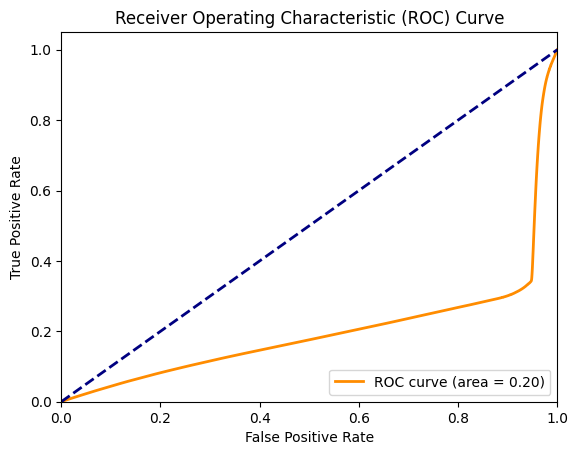

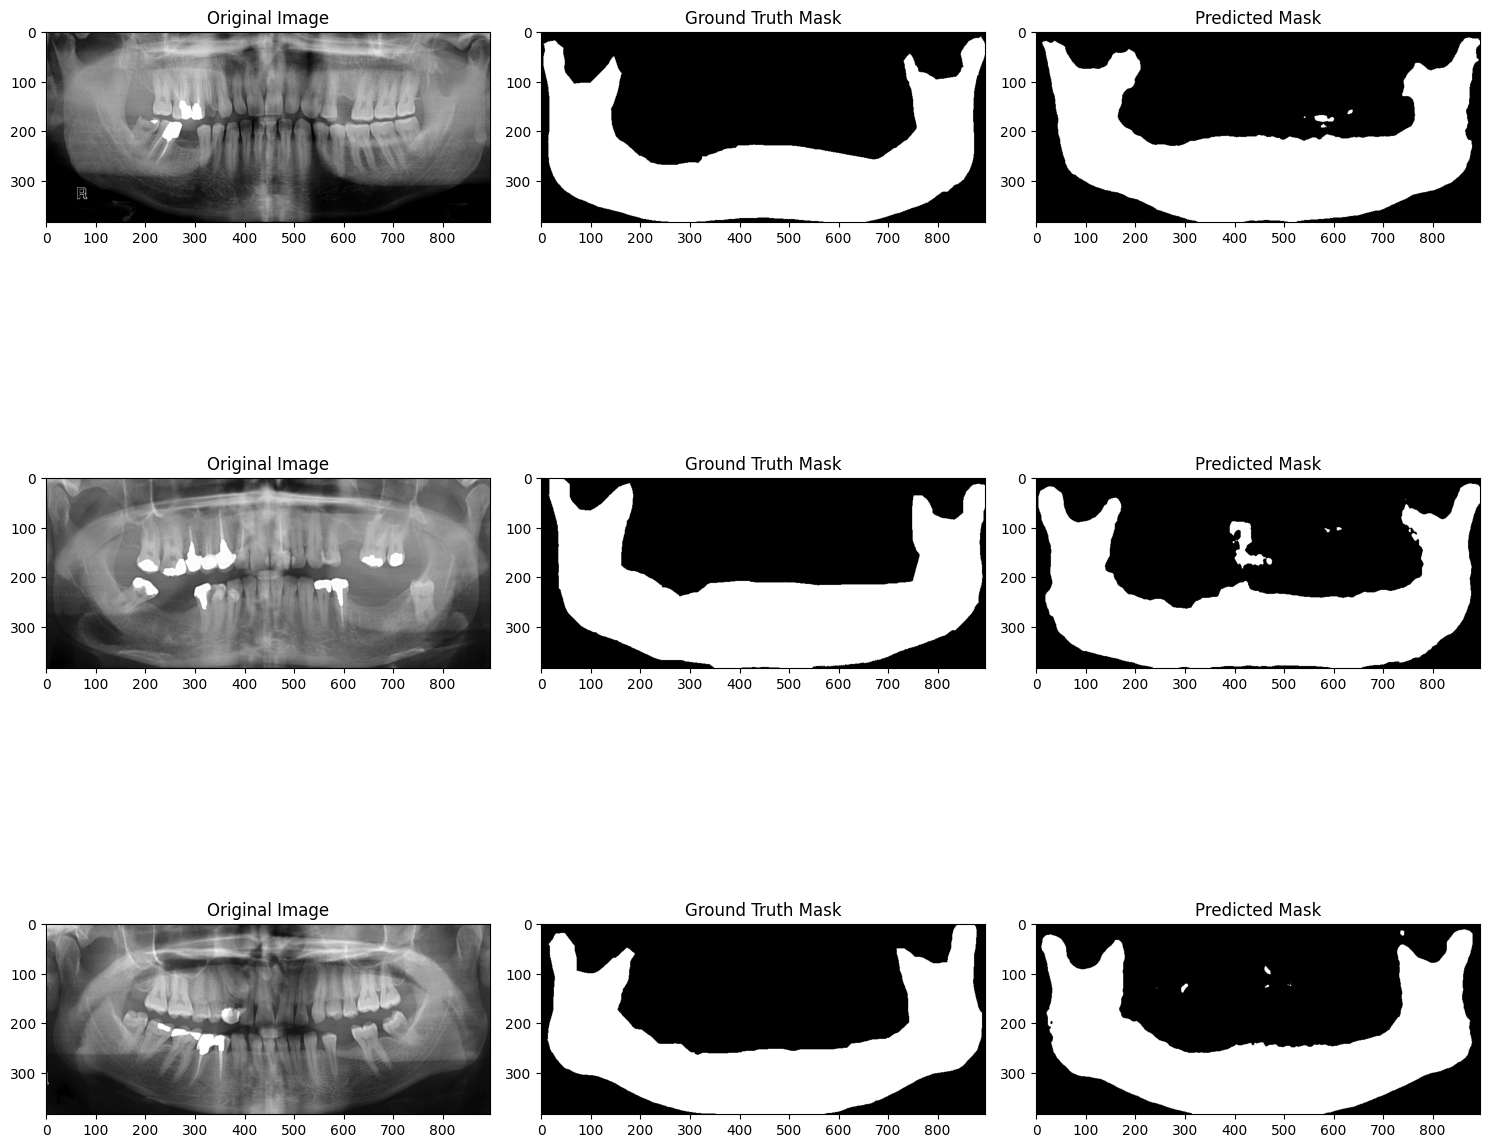

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score, jaccard_score

# define the test dataset
class MandibleTestDataset(Dataset):
    def __init__(self, path_to_images, path_to_masks, transform=None):
        self.path_to_images = path_to_images
        self.path_to_masks = path_to_masks
        self.transform = transform
        self.images = []
        self.masks = []

        for filename in os.listdir(self.path_to_images):
            img = cv2.imread(os.path.join(self.path_to_images, filename), 0)
            img = cv2.resize(img, (900, 400))
            img = self.pad(img)
            img -= img.min()
            img = img.astype(np.float32) / img.max()
            self.images.append(img)

        for filename in os.listdir(self.path_to_masks):
            mask = cv2.imread(os.path.join(self.path_to_masks, filename), 0)
            mask = cv2.resize(mask, (900, 400))
            mask = self.pad(mask)
            mask -= mask.min()
            mask = mask.astype(np.float32) / mask.max()
            mask = np.where(mask == np.unique(mask)[0], 0, 1)
            self.masks.append(mask)

    def pad(self, img):
        x = img.shape[0] - img.shape[0] % 32
        y = img.shape[1] - img.shape[1] % 32
        img = img[:x, :y]
        return img

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        if self.transform is not None:
            image = self.transform(image).contiguous()
            mask = self.transform(mask).contiguous()
        return image, mask

def evaluate_model(model, device, test_loader):
    model.eval()
    all_outputs = []
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            all_outputs.append(output.detach().cpu().numpy())
            all_targets.append(target.detach().cpu().numpy())
            predictions = np.where(output[:, 0, :, :].detach().cpu().numpy() > 0.5, 0, 1)
            all_predictions.append(predictions)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)
    all_predictions = np.concatenate(all_predictions, axis=0)

    return all_outputs, all_targets, all_predictions

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=1,
        classes=2,
        activation='sigmoid'
    )
    model = model.to(memory_format=torch.channels_last)
    model.to(device=device)

    # Load the saved model
    model.load_state_dict(torch.load('checkpoints/unet_model_best.pth'))

    # Define the test dataset
    path_to_test_images = '/content/drive/MyDrive/segmentasi/test/mandible/images'
    path_to_test_masks = '/content/drive/MyDrive/segmentasi/test/mandible/masks'
    test_dataset = MandibleTestDataset(path_to_test_images, path_to_test_masks, transform=transforms.ToTensor())
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Evaluate the model on the test dataset
    all_outputs, all_targets, predictions = evaluate_model(model, device, test_loader)

    # Calculate performance metrics
    cm = confusion_matrix(all_targets.flatten(), predictions.flatten())
    tn, fp, fn, tp = cm.ravel()
    accuracy = accuracy_score(all_targets.flatten(), predictions.flatten())
    f1 = f1_score(all_targets.flatten(), predictions.flatten())
    iou = jaccard_score(all_targets.flatten(), predictions.flatten())
    dice = 2 * tp / (2 * tp + fp + fn)
    fpr, tpr, _ = roc_curve(all_targets.flatten(), all_outputs[:, 0, :, :].flatten())
    roc_auc = auc(fpr, tpr)

    print(f'Confusion Matrix:\n{cm}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'IoU: {iou:.4f}')
    print(f'Dice Score: {dice:.4f}')

    # Plot the ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Visualize the results
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))

    for i in range(3):
        # Display the original image
        axes[i, 0].imshow(test_dataset[i][0].squeeze(), cmap='gray')
        axes[i, 0].set_title('Original Image')

        # Display the ground truth mask
        axes[i, 1].imshow(test_dataset[i][1].squeeze(), cmap='gray')
        axes[i, 1].set_title('Ground Truth Mask')

        # Display the predicted mask
        axes[i, 2].imshow(np.squeeze(predictions[i]), cmap='gray')
        axes[i, 2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()